In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import spacy
import nltk
from nltk.probability import FreqDist
import pickle as pkl
import re
import missingno as msno
import string

In [3]:
filename = "../NLP dataset/ner.csv"

In [4]:
text = pd.read_csv(filename)

In [5]:
#loading spacy ML model
nlp = spacy.load("en_core_web_sm")

/home/royale/.local/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
text.drop(columns= "labels", inplace= True)
text.rename(columns={"text": "news_headlines"}, inplace=True)

In [7]:
text

,news_headlines
0,Thousands of demonstrators have marched throug...
1,Iranian officials say they expect to get acces...
2,Helicopter gunships Saturday pounded militant ...
3,They left after a tense hour-long standoff wit...
4,U.N. relief coordinator Jan Egeland said Sunda...
...,...
47954,Opposition leader Mir Hossein Mousavi has said...
47955,"On Thursday , Iranian state media published a ..."
47956,"Following Iran 's disputed June 12 elections ,..."
47957,"Since then , authorities have held public tria..."


### Basic Text EDA

### Check for missing values with python's Missingno libraries

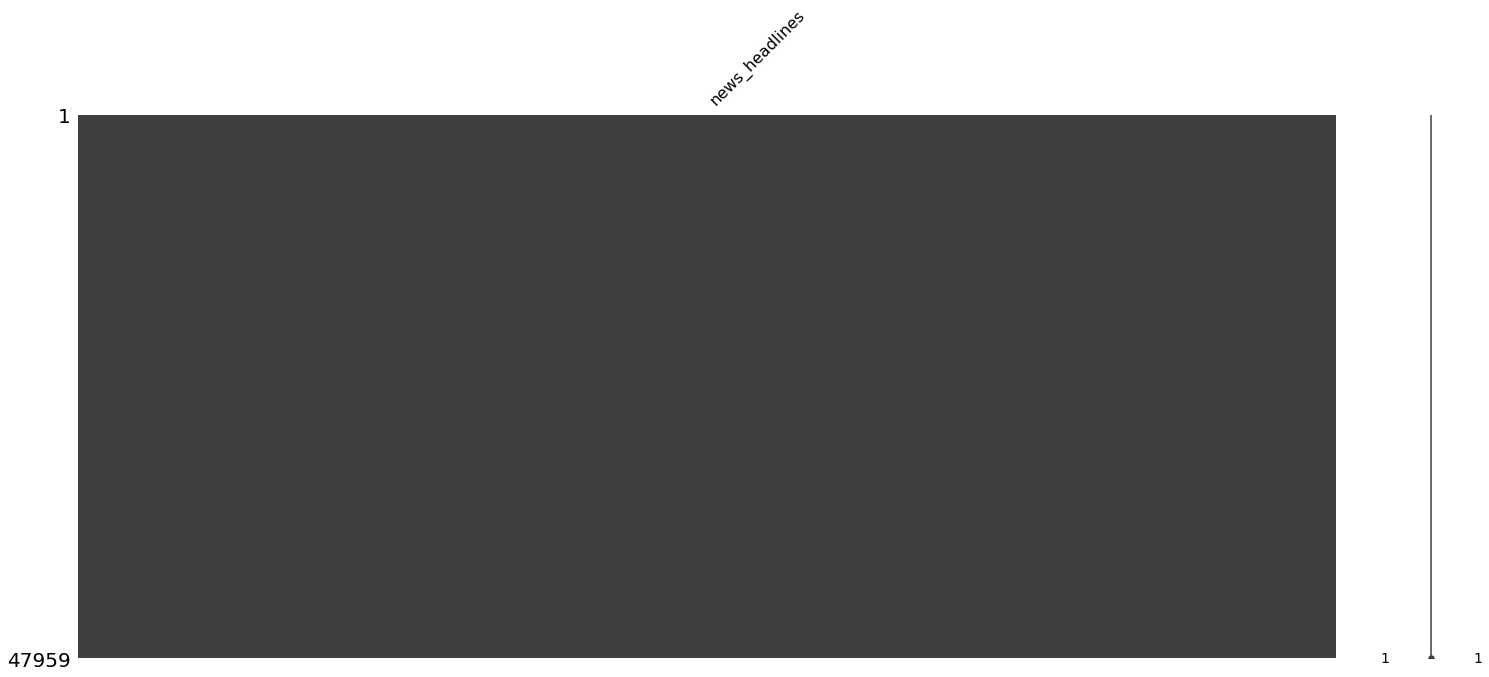

In [8]:
msno.matrix(text);

#### Text cleaning and preprocessing

In [9]:
text

,news_headlines
0,Thousands of demonstrators have marched throug...
1,Iranian officials say they expect to get acces...
2,Helicopter gunships Saturday pounded militant ...
3,They left after a tense hour-long standoff wit...
4,U.N. relief coordinator Jan Egeland said Sunda...
...,...
47954,Opposition leader Mir Hossein Mousavi has said...
47955,"On Thursday , Iranian state media published a ..."
47956,"Following Iran 's disputed June 12 elections ,..."
47957,"Since then , authorities have held public tria..."


In [10]:
inst = text["news_headlines"][1000]
inst

"Saturday 's violence came a day after Iraqi forces and U.S. soldiers raided a Sunni Muslim mosque in Baghdad known for its anti-American agitation and support for the former regime of Saddam Hussein ."

# Text Cleaning Steps:
- Removal of extra whitespaces. The EDA on every row of the headlines made me understand that there are extra white spaces on the news_headlines columns. This will be to strip the column of every extra spaces
- Removal of punctuations; punctuations do not really have any use on what I aim to achieve in this project.
- Removal of stopwords. 

#### All this cleaning will be done with python's regex module

In [12]:
def clean_text(corpus):
    # This function is used to remove punctuations in the text column
    corpus = re.sub('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~…“””–]+', "", corpus)
    corpus = corpus.strip()
    return corpus

cleaned_corpus = lambda x: clean_text(x)

In [13]:
text_copy = text.copy()

In [14]:
clean_corpus = pd.DataFrame(text_copy["news_headlines"].map(cleaned_corpus))

In [15]:
clean_corpus

,news_headlines
0,Thousands of demonstrators have marched throug...
1,Iranian officials say they expect to get acces...
2,Helicopter gunships Saturday pounded militant ...
3,They left after a tense hourlong standoff with...
4,UN relief coordinator Jan Egeland said Sunday ...
...,...
47954,Opposition leader Mir Hossein Mousavi has said...
47955,On Thursday Iranian state media published a m...
47956,Following Iran s disputed June 12 elections r...
47957,Since then authorities have held public trial...


## Using Spacy, tokenize the newsheadlines to extract the needed named entities

### Extraction of Named Entitiy: "LOCATIONS" in the news dataset

In [189]:
# A function to extract the location entity from the news_headlines column.
def location_tokens(headlines):
    news = nlp(headlines)
    locations = []
    for tokens in news.ents: #Spacy entity recognition
        if tokens.label_ == "GPE":
            locations.append(tokens)
    return locations
outcome = lambda x: location_tokens(x)

In [64]:
locations = clean_corpus["news_headlines"].map(outcome)
locations

0        [(London), (Iraq)]
1                        []
2               [(Orakzai)]
3                        []
4            [(US), (Aceh)]
                ...        
47954                    []
47955                    []
47956              [(Iran)]
47957                    []
47958         [(Indonesia)]
Name: news_headlines, Length: 47959, dtype: object

In [65]:
locations_list = locations.to_list()
loc = [j for j in locations_list if len(j) != 0]

In [66]:
big_loc = []
for k in loc:
    for m in k:
        big_loc.append(m.text.lower())

In [67]:
big_loc = [g.replace("the united states", "us") for g in big_loc]

In [190]:
loc_freq = nltk.FreqDist(big_loc) #NLTK word frquency for plotting of wordcloud

## WordCloud Of Locations recorded on the news dataset

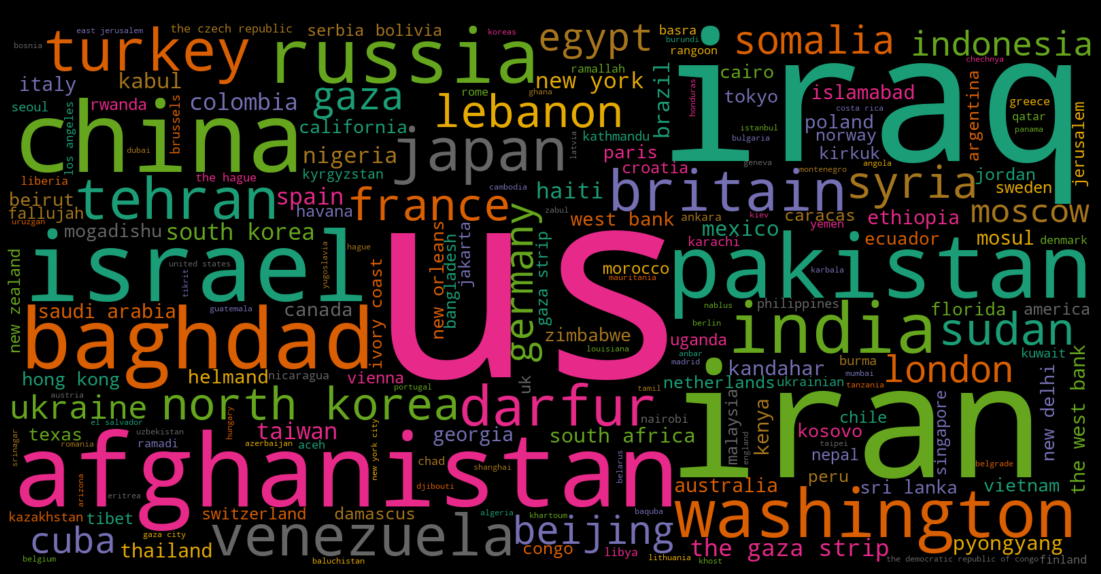

In [89]:
wrdcloud = WordCloud(stopwords= STOP_WORDS, background_color= "black", colormap= "Dark2", random_state= 1, collocations=False, width=1600, height=800)
plt.figure(figsize=(20, 10), facecolor="k")
freq = wrdcloud.generate_from_frequencies(loc_freq)
plt.tight_layout(pad=0)
plt.imshow(freq, interpolation="bilinear")
plt.axis("off");
plt.title("Location Entities From News Headlines")
plt.savefig("locations entities.svg")

## Extraction of Named Entitiy: "PERSONS" in the news dataset

In [72]:
def persons_tokens(headlines):
    news = nlp(headlines)
    persons = []
    for tokens in news.ents:
        if tokens.label_ == "PERSON":
            persons.append(tokens.text)
    return persons
outcome = lambda x: persons_tokens(x)

In [73]:
persons = clean_corpus["news_headlines"].map(outcome)
persons

0                                                []
1                                                []
2                                                []
3                                                []
4                                     [Jan Egeland]
                            ...                    
47954    [Mir Hossein Mousavi, Mahmoud Ahmadinejad]
47955                                            []
47956                                            []
47957                                            []
47958                                            []
Name: news_headlines, Length: 47959, dtype: object

In [85]:
persons_list = persons.to_list()
person = [p for p in persons_list if len(p) != 0]
person_ = []
for _person in person:
    for k in _person:
        person_.append(k.lower())

In [87]:
person_freq = nltk.FreqDist(person_)

## WordCloud Of Persons recorded on the news dataset

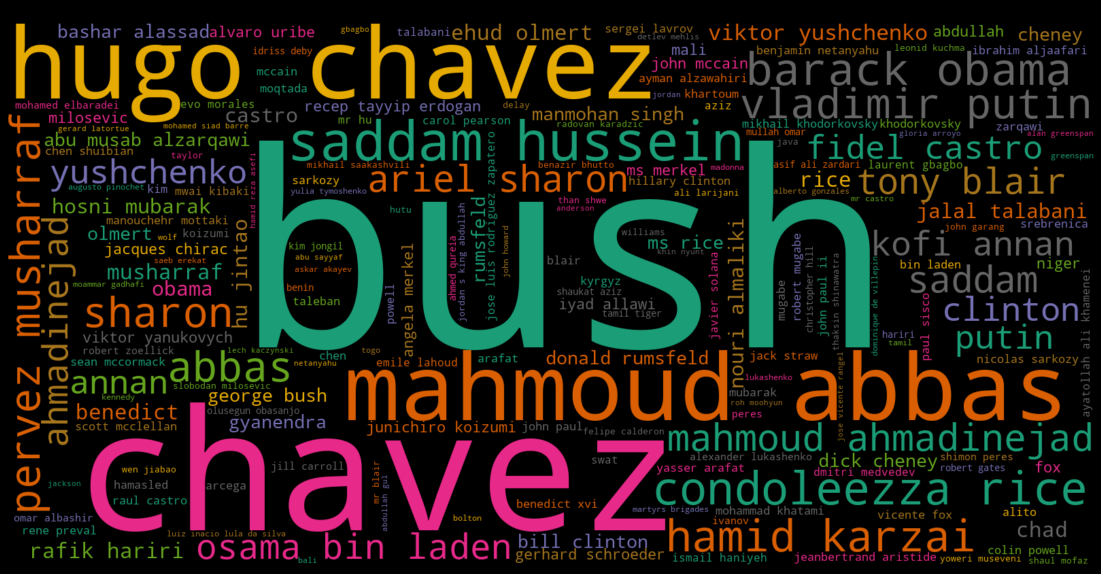

In [90]:
wrdcloud = WordCloud(background_color= "black", colormap= "Dark2", random_state= 1, collocations=False, width=1600, height=800)
plt.figure(figsize=(20, 10), facecolor="k")
freq = wrdcloud.generate_from_frequencies(person_freq)
plt.tight_layout(pad=0)
plt.imshow(freq, interpolation= "bilinear")
plt.axis("off")
plt.title("Persons Entities From News Headlines")
plt.savefig("persons_entities.svg")

## Exctraction of Named Entities: "ORGANIZATIONS" from the news_dataset

In [75]:
def org_tokens(headlines):
    news = nlp(headlines)
    organisations = []
    for tokens in news.ents:
        if tokens.label_ == "ORG":
            organisations.append(tokens.text)
    return organisations
outcome = lambda x: org_tokens(x)

In [76]:
org = clean_corpus["news_headlines"].map(outcome)
org

0                            []
1                        [IAEA]
2                     [Taliban]
3                            []
4                          [UN]
                  ...          
47954                        []
47955    [Revolutionary Guards]
47956                        []
47957                        []
47958      [The United Nations]
Name: news_headlines, Length: 47959, dtype: object

In [149]:
def org_cleaning(col_value):
    col_value = col_value.to_list()
    val = [l for l in col_value if len(l) != 0]
    val_ = []
    for _val in val:
        for c in _val:
            val_.append(c.lower())
    val_ = [o.replace("united nations", "un") for o in val_]
    val_ = [o.replace("the united nations", "un") for o in val_]
    val_ = [o.replace("the un", "un") for o in val_]
    val_ = [o.replace("european union", "eu") for o in val_]
    val_ = [o.replace("the eu", "eu") for o in val_]
    val_ = [o.replace("world health organization", "WHO") for o in val_]
    val_ = [o.replace("the world health organization", "WHO") for o in val_]
    val_ = [o.replace("the WHO", "WHO") for o in val_]
    val_ = [o.replace("the us", "us") for o in val_]
    return val_

## WordCloud showing "ORGANIZATIONS" extracted from the news dataset

In [172]:
org_freq = nltk.FreqDist(org_cleaning(org))

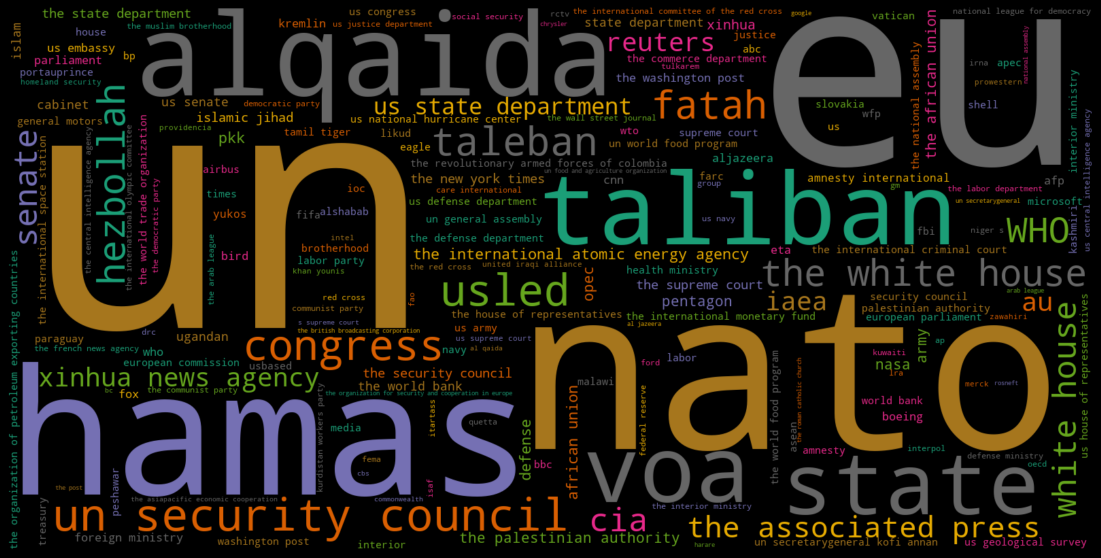

In [175]:
wrdcloud = WordCloud(background_color="black", colormap="Dark2", random_state=1, collocations=False, width=1600, height=800)
plt.figure(figsize=(20, 10), facecolor="k")
freq = wrdcloud.generate_from_frequencies(org_freq)
plt.tight_layout(pad=0)
plt.imshow(freq, interpolation="bilinear")
plt.axis("off");
plt.savefig("Organizations entities.svg")

In [177]:
big_text_list = clean_corpus["news_headlines"].values.tolist()

In [192]:
big_text = "" # a place holder for all the text
for _text in big_text_list:
    big_text = big_text + _text + " "

### Turn the big_text into a spacy object

In [179]:
big_text = big_text.lower().strip()

### Remove Numbers from the text

In [180]:
big_text = re.sub("\d+", "", big_text)
big_text = re.sub(r"\s+", " ", big_text).strip()

In [187]:
STOP_WORDS.add("mr")

## A wordcloud of the collation of all the words on the news headlines dataset

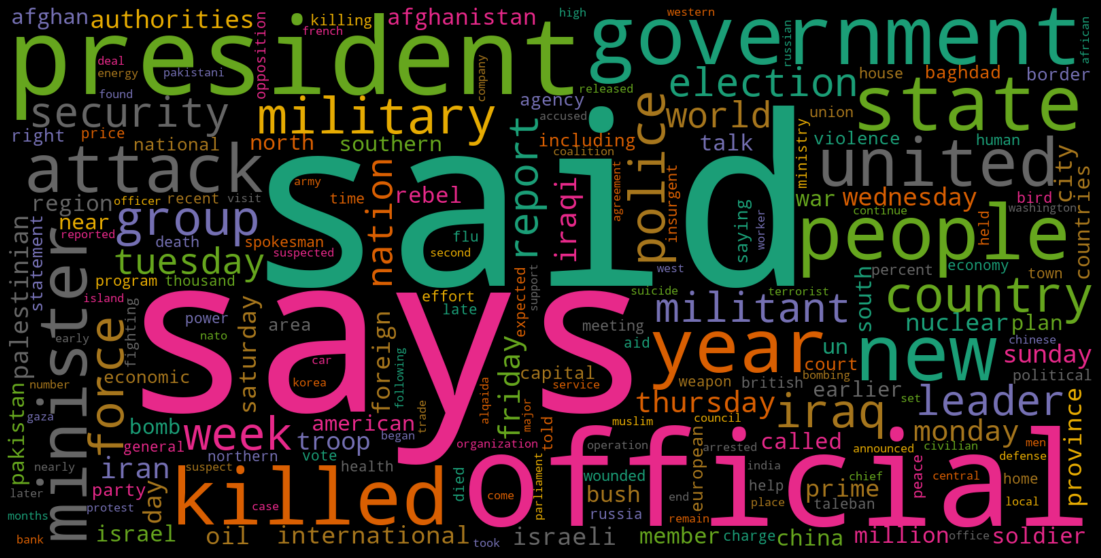

In [188]:
wrdcloud = WordCloud(stopwords=STOP_WORDS, background_color= "black", colormap= "Dark2", random_state= 1, collocations=False, width=1600, height=800)
plt.figure(figsize=(20, 10), facecolor="k")
freq = wrdcloud.generate_from_text(big_text)
plt.tight_layout(pad=0)
plt.imshow(freq, interpolation="bilinear")
plt.axis("off")
plt.savefig("wdcloud.svg")